# K-Means Clustering

**K-Means** es un algoritmo de clustering que particiona los datos en K grupos basándose en la minimización de la variación dentro de cada grupo. A continuación, se detalla el proceso completo para aplicar K-Means al dataset.

## 1. Preparación de los Datos

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilos de visualización
sns.set(style="whitegrid")
%matplotlib inline

# Carga del dataset (ya limpio de valores faltantes)
df = pd.read_csv('movie_data.csv', sep=';').dropna()

# Transformación de 'release_date' a tipo datetime y extracción del año
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d')
df['release_year'] = df['release_date'].dt.year

# Verificación de la estructura del DataFrame
print("Estructura del DataFrame:")
print(df.head())

from sklearn.preprocessing import StandardScaler

# Selección de variables numéricas
numerical_features = [
    'budget', 'popularity', 'production_companies',
    'production_countries', 'revenue', 'runtime',
    'spoken_languages', 'vote_average', 'vote_count',
    'release_year'
]

# Transformación de variables categóricas ('genres') usando One-Hot Encoding
# genres_dummies = pd.get_dummies(df['genres'], prefix='genre')

# Combinación de variables numéricas y categóricas
X = pd.concat([df[numerical_features]], axis=1).values  # Convertimos a numpy array

# Escalado de las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Verificación de las primeras filas escaladas
print("\nPrimeras filas del conjunto de datos escalado:")
print(X_scaled[:5])

Estructura del DataFrame:
       budget     genres    imdb_id     original_title  \
0  30000000.0  Animation  tt0114709          Toy Story   
1  65000000.0  Adventure  tt0113497            Jumanji   
2  16000000.0     Comedy  tt0114885  Waiting to Exhale   
3  60000000.0     Action  tt0113277               Heat   
4  35000000.0     Action  tt0114576       Sudden Death   

                                            overview  popularity  \
0  Led by Woody, Andy's toys live happily in his ...   21.946943   
1  When siblings Judy and Peter discover an encha...   17.015539   
2  Cheated on, mistreated and stepped on, the wom...    3.859495   
3  Obsessive master thief, Neil McCauley leads a ...   17.924927   
4  International action superstar Jean Claude Van...    5.231580   

   production_companies  production_countries release_date      revenue  \
0                   1.0                   1.0   1995-10-30  373554033.0   
1                   3.0                   1.0   1995-12-15  262797

## 2. Implementación de K-Means desde Cero

A continuación, implementaremos la clase `KMeansFromScratch` que permitirá:

- Inicializar centroides aleatorios.
- Asignar puntos al cluster más cercano según una métrica de distancia.
- Actualizar los centroides basándose en los puntos asignados.
- Calcular la inercia (suma de las distancias al cuadrado de los puntos a sus centroides).

### 2.1. Definición de Métricas de Distancia

In [7]:
def euclidean_distance(a, b):
    """Calcula la distancia Euclidiana entre dos puntos."""
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan_distance(a, b):
    """Calcula la distancia de Manhattan entre dos puntos."""
    return np.sum(np.abs(a - b))

def chebyshev_distance(a, b):
    """Calcula la distancia de Chebyshev entre dos puntos."""
    return np.max(np.abs(a - b))

def cosine_distance(a, b):
    """Calcula la distancia de Coseno entre dos puntos."""
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return 1 - dot_product / (norm_a * norm_b)

### 2.2. Clase `KMeansFromScratch`

In [8]:
class KMeansFromScratch:
    def __init__(self, n_clusters=4, max_iters=100, distance_metric='euclidean', tol=1e-4, verbose=False):
        """
        Inicializa el algoritmo K-Means.
        
        Parámetros:
        - n_clusters: Número de clusters.
        - max_iters: Número máximo de iteraciones.
        - distance_metric: Métrica de distancia ('euclidean').
        - tol: Tolerancia para la convergencia.
        - verbose: Si es True, imprime información durante el entrenamiento.
        """
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.distance_metric = distance_metric
        self.tol = tol
        self.verbose = verbose
        self.centroids = None
        self.labels = None
        self.inertia_ = None  # Suma de las distancias al cuadrado
        
        # Asignación de la función de distancia
        if self.distance_metric == 'euclidean':
            self.distance_func = euclidean_distance
        else:
            raise ValueError("Métrica de distancia no soportada.")
    
    def initialize_centroids(self, X):
        """Inicializa los centroides seleccionando aleatoriamente K puntos del dataset."""
        np.random.seed(42)  # Para reproducibilidad
        random_indices = np.random.permutation(X.shape[0])[:self.n_clusters]
        self.centroids = X[random_indices]
        if self.verbose:
            print(f"Centroides iniciales:\n{self.centroids}\n")
    
    def assign_clusters(self, X):
        """Asigna cada punto al cluster cuyo centroide está más cercano."""
        labels = []
        for idx, point in enumerate(X):
            distances = [self.distance_func(point, centroid) for centroid in self.centroids]
            closest_cluster = np.argmin(distances)
            labels.append(closest_cluster)
            if self.verbose and idx < 5:  # Mostrar las primeras 5 asignaciones
                print(f"Punto {idx}: Asignado al cluster {closest_cluster} con distancia {distances[closest_cluster]:.4f}")
        return np.array(labels)
    
    def update_centroids(self, X, labels):
        """Actualiza los centroides calculando el promedio de los puntos asignados a cada cluster."""
        new_centroids = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else self.centroids[i] for i in range(self.n_clusters)])
        return new_centroids
    
    def calculate_inertia(self, X):
        """Calcula la inercia como la suma de las distancias al cuadrado de cada punto a su centroide."""
        inertia = 0.0
        for idx, point in enumerate(X):
            centroid = self.centroids[self.labels[idx]]
            distance = self.distance_func(point, centroid)
            inertia += distance ** 2
        return inertia
    
    def fit(self, X):
        """Entrena el modelo K-Means sobre el dataset X."""
        self.initialize_centroids(X)
        for i in range(self.max_iters):
            if self.verbose:
                print(f"Iteración {i+1}")
            
            # Asignación de clusters
            labels = self.assign_clusters(X)
            
            # Verificación de clusters vacíos
            empty_clusters = [idx for idx in range(self.n_clusters) if np.sum(labels == idx) == 0]
            if empty_clusters:
                if self.verbose:
                    print(f"Clusters vacíos encontrados: {empty_clusters}. Reinicializando centroides.")
                for idx in empty_clusters:
                    self.centroids[idx] = X[np.random.choice(len(X))]
            
            # Actualización de centroides
            new_centroids = self.update_centroids(X, labels)
            
            # Cálculo de la diferencia entre los nuevos y antiguos centroides
            centroid_shifts = np.linalg.norm(new_centroids - self.centroids, axis=1)
            if self.verbose:
                print(f"Desplazamiento de centroides: {centroid_shifts}\n")
            
            # Verificación de la convergencia
            if np.all(centroid_shifts <= self.tol):
                if self.verbose:
                    print("Convergencia alcanzada.\n")
                break
            
            self.centroids = new_centroids
        
        self.labels = labels
        self.centroids = new_centroids
        self.inertia_ = self.calculate_inertia(X)
    
    def predict(self, X):
        """Asigna clusters a nuevos puntos basándose en los centroides entrenados."""
        return self.assign_clusters(X)

### 2.3. Método del Codo para Determinar K Óptimo

In [9]:
from kneed import KneeLocator

def elbow_method(X, max_K=10, distance_metric='euclidean', verbose=False):
    """
    Aplica el método del codo para determinar el número óptimo de clusters.
    
    Parámetros:
    - X: Datos escalados.
    - max_K: Máximo número de clusters a evaluar.
    - distance_metric: Métrica de distancia a utilizar.
    - verbose: Si es True, imprime información durante el entrenamiento.
    
    Retorna:
    - best_K: Número óptimo de clusters determinado por el método del codo.
    - K_range: Rango de K evaluados.
    - inertia_values: Inercia correspondiente a cada K.
    """
    inertia_values = []
    K_range = range(1, max_K + 1)
    
    for K in K_range:
        kmeans = KMeansFromScratch(n_clusters=K, max_iters=100, distance_metric=distance_metric, verbose=verbose)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)
        if verbose:
            print(f"K={K}, Inercia={kmeans.inertia_:.2f}")
    
    # Identificación del "codo" utilizando KneeLocator
    kn = KneeLocator(K_range, inertia_values, curve='convex', direction='decreasing')
    best_K = kn.knee
    if best_K is None:
        best_K = 4  # Valor por defecto si no se detecta el codo
    
    print(f"\nMejor K según el método del codo: {best_K}")
    
    # Gráfico del Método del Codo para este conjunto de características
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, inertia_values, 'bo-', markersize=8, label='Inercia')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Inercia')
    plt.title('Método del Codo para Determinar K Óptimo')
    plt.xticks(K_range)
    plt.axvline(x=best_K, color='red', linestyle='--', label=f'K={best_K}')
    plt.legend()
    plt.show()
    
    return best_K, K_range, inertia_values

### 2.4. Aplicación del Método del Codo


Mejor K según el método del codo: 5


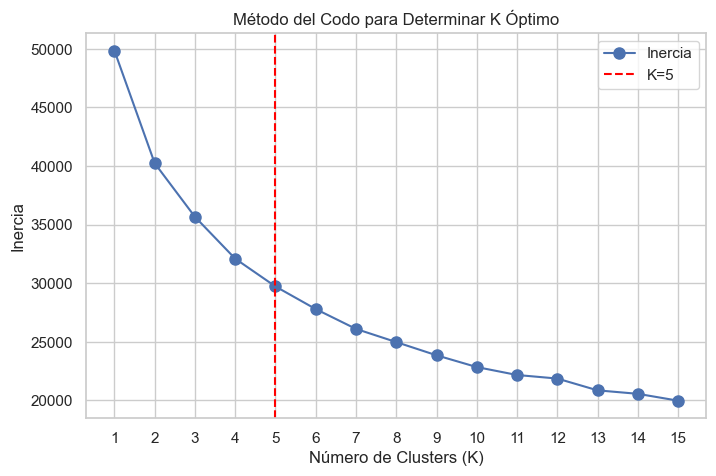

In [10]:
# Aplicación del Método del Codo
best_K, K_range, inertia_values = elbow_method(X_scaled, max_K=15, distance_metric='euclidean', verbose=False)


### 2.5. Aplicación de K-Means con K Óptimo

In [11]:
# Inicialización y entrenamiento del modelo K-Means
kmeans_optimal = KMeansFromScratch(n_clusters=best_K, max_iters=100, distance_metric='euclidean', verbose=True)
kmeans_optimal.fit(X_scaled)

# Asignación de etiquetas al DataFrame original
df['kmeans_cluster'] = kmeans_optimal.labels

# Verificación de la asignación de clusters
print("\nAsignación de clusters a las primeras filas:")
print(df[['original_title', 'kmeans_cluster']].head())

Centroides iniciales:
[[ 2.11794121  2.89495745 -0.42319459 -0.46617377  2.98011391 -0.85070755
  -0.52634212  1.34817875  4.5858622   0.09718531]
 [-0.59092032  0.0105746  -0.8849288  -0.46617377 -0.52202964 -0.57194536
  -0.52634212 -0.6524798  -0.46808824  0.48421812]
 [-0.54028739 -0.63550618  0.03853961  0.83691657 -0.45758655 -0.525485
  -0.52634212 -1.87510448 -0.55417758 -0.16083657]
 [-0.75041403 -1.1977429   0.03853961 -0.46617377 -0.57095099 -0.94362828
  -0.52634212 -0.6524798  -0.59469021  0.35520718]
 [-0.52762916 -0.76475787  0.03853961  0.83691657 -0.4979481  -0.99008865
  -0.52634212 -1.98625217 -0.56092968 -0.61237486]]

Iteración 1
Punto 0: Asignado al cluster 0 con distancia 2.7716
Punto 1: Asignado al cluster 1 con distancia 3.7995
Punto 2: Asignado al cluster 1 con distancia 1.9266
Punto 3: Asignado al cluster 1 con distancia 5.0978
Punto 4: Asignado al cluster 3 con distancia 1.4801
Desplazamiento de centroides: [2.65508416 1.62793976 2.14161585 1.18201229 1.8878

### 2.6. Visualización de los Clusters utilizando PCA

Para visualizar los clusters en un espacio bidimensional, reduciremos la dimensionalidad de los datos utilizando PCA (Análisis de Componentes Principales).

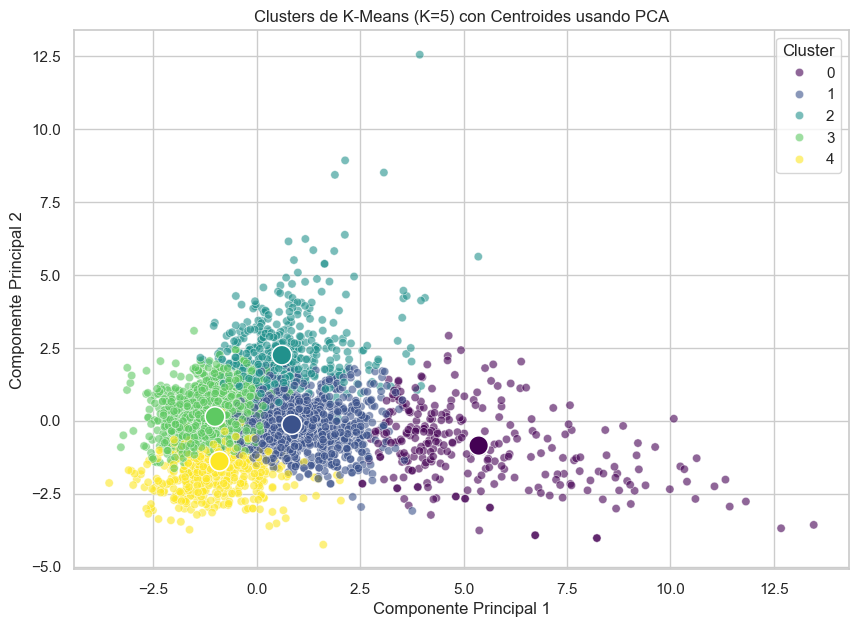

In [12]:
from sklearn.decomposition import PCA

# Reducción de dimensionalidad a 2 componentes para todos los datos
pca_all = PCA(n_components=2, random_state=42)
X_pca_all = pca_all.fit_transform(X_scaled)

# Creación de un DataFrame con las componentes principales y las etiquetas de cluster
pca_df_all = pd.DataFrame(data=X_pca_all, columns=['Componente 1', 'Componente 2'])
pca_df_all['Cluster'] = kmeans_optimal.labels

# Cálculo de las coordenadas de los centroides en el espacio PCA
centroids_pca = pca_all.transform(kmeans_optimal.centroids)

# Creación de un DataFrame para los centroides
centroids_df = pd.DataFrame(data=centroids_pca, columns=['Componente 1', 'Componente 2'])
centroids_df['Cluster'] = range(best_K)

# Gráfico de clusters con centroides
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Componente 1',
    y='Componente 2',
    hue='Cluster',
    palette='viridis',
    data=pca_df_all,
    alpha=0.6
)
sns.scatterplot(
    x='Componente 1',
    y='Componente 2',
    hue='Cluster',
    palette='viridis',
    data=centroids_df,
    markers='X',
    s=200,
    legend=False
)
plt.title(f'Clusters de K-Means (K={best_K}) con Centroides usando PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

### 2.7. Análisis de las Características de Cada Cluster

Analizaremos las características promedio de cada grupo para interpretar su significado.

In [13]:
# Agrupación de datos por cluster y cálculo de estadísticas descriptivas
cluster_summary = df.groupby('kmeans_cluster')[numerical_features].mean().reset_index()
print("\nResumen de características por cluster:")
print(cluster_summary)


Resumen de características por cluster:
   kmeans_cluster        budget  popularity  production_companies  \
0               0  1.318045e+08   21.599424              3.669065   
1               1  4.637009e+07   12.037709              3.357937   
2               2  3.069140e+07    9.593765              6.116505   
3               3  1.801269e+07    6.447390              2.220683   
4               4  8.255876e+06    7.639067              1.732026   

   production_countries       revenue     runtime  spoken_languages  \
0              1.435252  5.781262e+08  124.395683          1.708633   
1              1.187302  1.328177e+08  116.544444          1.492063   
2              2.970874  5.806198e+07  112.537864          2.126214   
3              1.138966  3.118695e+07  101.056787          1.266390   
4              1.143791  3.338531e+07  119.624837          1.615686   

   vote_average   vote_count  release_year  
0      6.851439  4266.071942   2007.877698  
1      6.618254  1097.92936

## 3. Loop para Evaluar Todos los Pares de Variables

Implementaremos un loop que iterará sobre todos los pares posibles de columnas numéricas, determinará el mejor K mediante el método del codo y graficará los clusters en 2D.

### 3.1. Loop para Evaluar Cada Par de Variables

Implementaremos un loop que:

1. Seleccione un par de características.
2. Extraiga los datos correspondientes.
3. Escale los datos.
4. Determine el mejor K mediante el método del codo.
5. Entrene K-Means con el K óptimo.
6. Grafique los clusters en 2D.

In [14]:
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

def run_kmeans_on_pair(df, pair, max_K=10, distance_metric='euclidean'):
    """
    Ejecuta K-Means en un par de características, determina el mejor K mediante el método del codo y grafica los clusters en valores originales.
    
    Parámetros:
    - df: DataFrame original con las características.
    - pair: Tuple con los nombres de las dos columnas a utilizar.
    - max_K: Máximo número de clusters a evaluar.
    - distance_metric: Métrica de distancia a utilizar.
    
    Retorna:
    - best_K: Número óptimo de clusters determinado por el método del codo.
    """
    feature1, feature2 = pair
    print(f"\nProcesando par de características: ({feature1}, {feature2})")
    
    # Extracción de las dos características
    X_pair = df[[feature1, feature2]].values
    
    # Escalado de las características
    scaler_pair = StandardScaler()
    X_pair_scaled = scaler_pair.fit_transform(X_pair)
    
    # Aplicación del Método del Codo
    inertia_values = []
    K_range = range(1, max_K + 1)
    
    for K in K_range:
        kmeans = KMeansFromScratch(n_clusters=K, max_iters=100, distance_metric=distance_metric, verbose=False)
        kmeans.fit(X_pair_scaled)
        inertia_values.append(kmeans.inertia_)
    
    # Identificación del "codo" utilizando KneeLocator
    kn = KneeLocator(K_range, inertia_values, curve='convex', direction='decreasing')
    best_K = kn.knee
    if best_K is None:
        best_K = 4  # Valor por defecto si no se detecta el codo
    
    print(f"Mejor K según el método del codo: {best_K}")
    
    # Gráfico del Método del Codo para este par de características
    plt.figure(figsize=(6, 4))
    plt.plot(K_range, inertia_values, 'bo-', markersize=6, label='Inercia')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Inercia')
    plt.title(f'Método del Codo para {feature1} vs {feature2}')
    plt.xticks(K_range)
    plt.axvline(x=best_K, color='red', linestyle='--', label=f'K={best_K}')
    plt.legend()
    plt.show()
    
    # Entrenamiento de K-Means con el mejor K
    kmeans_optimal = KMeansFromScratch(n_clusters=best_K, max_iters=100, distance_metric=distance_metric, verbose=False)
    kmeans_optimal.fit(X_pair_scaled)
    
    # Asignación de etiquetas
    labels = kmeans_optimal.labels
    
    # Inversión de la escala para graficar en valores originales
    X_pair_original = scaler_pair.inverse_transform(X_pair_scaled)
    centroids_original = scaler_pair.inverse_transform(kmeans_optimal.centroids)
    
    # Creación de un DataFrame para graficar
    plot_df = pd.DataFrame({
        feature1: X_pair_original[:, 0],
        feature2: X_pair_original[:, 1],
        'Cluster': labels
    })
    
    # Creación de un DataFrame para los centroides
    centroids_df = pd.DataFrame({
        feature1: centroids_original[:, 0],
        feature2: centroids_original[:, 1],
        'Cluster': range(best_K)
    })
    
    # Gráfico de clusters en valores originales
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x=feature1,
        y=feature2,
        hue='Cluster',
        palette='viridis',
        data=plot_df,
        alpha=0.6
    )
    # Graficar los centroides
    sns.scatterplot(
        x=feature1,
        y=feature2,
        hue='Cluster',
        palette='viridis',
        data=centroids_df,
        markers='X',
        s=200,
        legend=False
    )
    plt.title(f'Clusters de K-Means (K={best_K})\n{feature1} vs {feature2}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(title='Cluster')
    plt.show()
    
    return best_K


### 3.2. Ejecución del Loop para Todos los Pares de Características

Ahora, ejecutaremos el loop para evaluar cada par de características.

Total de pares de características: 45

Procesando par de características: (budget, popularity)
Mejor K según el método del codo: 3


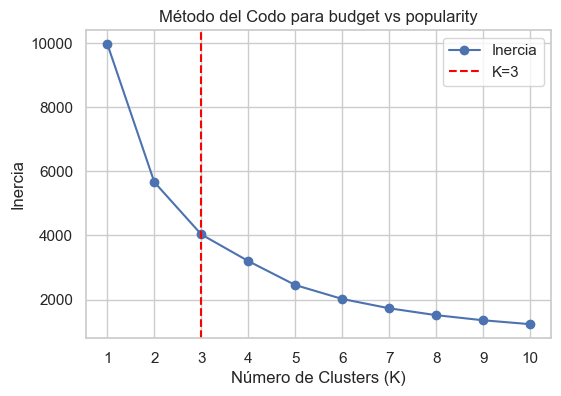

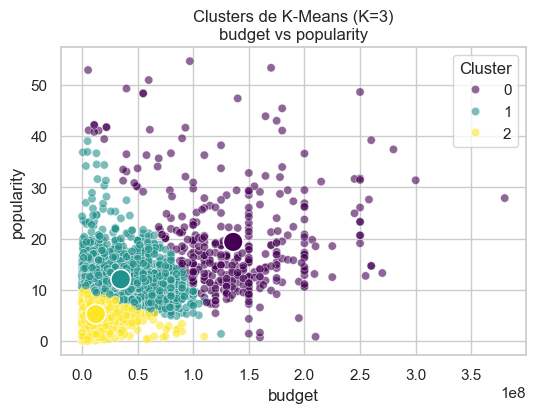


Procesando par de características: (budget, production_companies)
Mejor K según el método del codo: 3


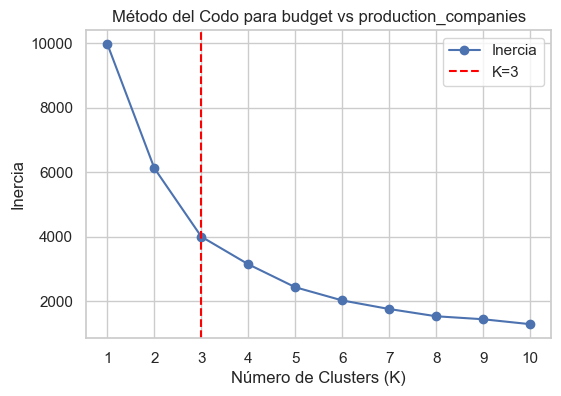

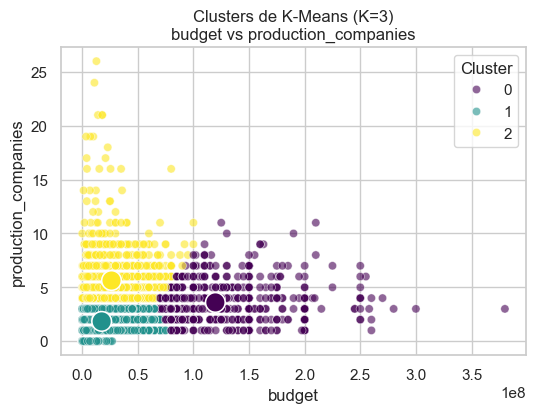


Procesando par de características: (budget, production_countries)


KeyboardInterrupt: 

In [15]:
from itertools import combinations

# Generación de todos los pares posibles de columnas numéricas sin duplicados
feature_pairs = list(combinations(numerical_features, 2))
print(f"Total de pares de características: {len(feature_pairs)}")

# Loop para evaluar cada par
for pair in feature_pairs:
    best_K = run_kmeans_on_pair(df, pair, max_K=10, distance_metric='euclidean')